In [42]:
import re
import csv
from collections import defaultdict
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D

This Jupyter code aims to analyze the sequence of executed and planned orders to derive insight by:  
  
1) Defining file paths  
2) Defining a regex pattern to extract scheduled orders for straddle carriers (SCs)  
3) Reading and extracting scheduled SC orders from the optimizer log file  
4) Mapping origin and destination locations for a specific SC  
5) Organizing executed orders for each SC, including any waiting steps before execution  
6) Categorizing locations into different groups  
7) Visualize the Executed Orders of a Specific SC as a directed graph  


In [43]:
# ---------------------------------------------
# Define file paths
# ---------------------------------------------


log_file_path = "logger_all.log"  # Input log file
processed_log = "processed_log/processed_log_all_SCs_jobs.csv"  # Input all SC jobs
matched_lines_path = "matched_lines_orders_scheduled.txt"  # Output file with matched lines
csv_schedule_path = "order_sequence/scheduled_orders.csv"  # Final CSV output
csv_executed_path = "order_sequence/executed_orders.csv"  # Final CSV output




In [44]:
# ---------------------------------------------
# Define and apply a regex pattern to extract scheduled orders for straddle carriers
# ---------------------------------------------


log_pattern = re.compile(
    r"(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}) INFO (SC\d{3}) schedule (.+)"
)

try:
    # Open the log file for reading and a new file to store matched lines
    with open(log_file_path, "r") as file, open(matched_lines_path, "w") as match_file:
        for line in file:
            match = log_pattern.search(line)  # Search for matching log entries
            if match:
                match_file.write(line)  # Write matched lines to output file
except FileNotFoundError:
    print(f"Error: Log file '{log_file_path}' not found.")  
except Exception as e:
    print(f"An error occurred while processing the log file: {e}")  

In [45]:
# ---------------------------------------------
# Read and extract scheduled orders for SCs by optimizer from the log file
# ---------------------------------------------


# Initialize a dictionary to store schedule data for each SC
schedule_data = {}

# Read the log file and extract schedule information
with open(log_file_path, "r") as file:
    for line in file:
        match = log_pattern.search(line)  # Search for scheduled job entries in the log
        if match:
            timestamp, sc_number, schedule_info = match.groups()
            
            # Initialize a list for this SC if it doesn't exist
            if sc_number not in schedule_data:
                schedule_data[sc_number] = []
                
            # Split the schedule information by commas (each entry represents a job)
            to_co_entries = schedule_info.split(",")

            # Extract the order values 
            for entry in to_co_entries:
                to_co_value = entry.split(":")[1].split("#")[0]  # Extract TO_CO_TFTU value
                
                # Avoid duplicate consecutive values in the list
                if not schedule_data[sc_number] or schedule_data[sc_number][-1] != to_co_value:
                    schedule_data[sc_number].append(to_co_value)

# Convert the extracted schedule data into a pandas DataFrame
schedule_df = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in schedule_data.items()]))

# Save the processed schedule data to a CSV file
schedule_df.to_csv(csv_schedule_path, index=False)

print(schedule_df.head(20))


               SC001             SC002             SC003             SC004  \
0   TO_CO_TFTU000018  TO_CO_TFTU000023  TO_CO_TFTU000020  TO_CO_TFTU000001   
1   TO_CO_TFTU000053  TO_CO_TFTU000025  TO_CO_TFTU000026  TO_CO_TFTU000047   
2   TO_CO_TFTU000018  TO_CO_TFTU000023  TO_CO_TFTU000020  TO_CO_TFTU000001   
3   TO_CO_TFTU000053  TO_CO_TFTU000025  TO_CO_TFTU000024  TO_CO_TFTU000045   
4   TO_CO_TFTU000018  TO_CO_TFTU000023  TO_CO_TFTU000020  TO_CO_TFTU000001   
5   TO_CO_TFTU000033  TO_CO_TFTU000053  TO_CO_TFTU000034  TO_CO_TFTU000032   
6   TO_CO_TFTU000018  TO_CO_TFTU000023  TO_CO_TFTU000020  TO_CO_TFTU000001   
7   TO_CO_TFTU000051  TO_CO_TFTU000053  TO_CO_TFTU000034  TO_CO_TFTU000031   
8   TO_CO_TFTU000018  TO_CO_TFTU000023  TO_CO_TFTU000020  TO_CO_TFTU000001   
9   TO_CO_TFTU000051  TO_CO_TFTU000056  TO_CO_TFTU000032  TO_CO_TFTU000036   
10  TO_CO_TFTU000018  TO_CO_TFTU000023  TO_CO_TFTU000020  TO_CO_TFTU000001   
11  TO_CO_TFTU000033  TO_CO_TFTU000053  TO_CO_TFTU000032  TO_CO_

In [46]:
# ---------------------------------------------
# Process scheduled orders: Add origin and destination locations for a specific SC
# ---------------------------------------------


SC = "SC012"  # Define the SC to analyze

# Read the input Excel files
df_locations = pd.read_excel("input_simu/VOSimu-InputInformation.xlsx", sheet_name="Locations")
df_orders = pd.read_excel("input_simu/VOSimu-InputInformation.xlsx", sheet_name="ContainerOrders")

# Clean data: Strip whitespace from all string columns to avoid mismatches
df_locations = df_locations.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df_orders = df_orders.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Rename columns in df_locations for clarity
df_locations.rename(columns={"Location Name": "Location", "X-Coordinate [mm]": "X", "Y-Coordinate [mm]": "Y"}, inplace=True)

# Merge location coordinates with orders to get Origin and Destination locations
df_orders = df_orders.merge(df_locations, left_on="OriginLocation", right_on="Location", how="left")
df_orders.rename(columns={"X": "X_Origin", "Y": "Y_Origin"}, inplace=True)

df_orders = df_orders.merge(df_locations, left_on="DestinationLocation", right_on="Location", how="left")
df_orders.rename(columns={"X": "X_Dest", "Y": "Y_Dest"}, inplace=True)

# Extract the scheduled order IDs for the given SC
tractor_schedule_list = schedule_df[f"{SC}"].dropna().tolist() 

# Initialize a list to store processed order data
ordered_data = []

# Match scheduled order IDs with their respective origin and destination locations
for ID in tractor_schedule_list:
    row = df_orders[df_orders["TractorOrderId"] == ID]  # Find the corresponding order
    
    if not row.empty:
        origin = row["OriginLocation"].values[0]
        destination = row["DestinationLocation"].values[0]
        ordered_data.append({"TractorOrderId": ID, "Origin": origin, "Destination": destination})

# Convert processed data into a DataFrame
schedule_df_sc = pd.DataFrame(ordered_data)

# Save the processed SC schedule with origin and destination information
schedule_df_sc.to_csv(f"order_sequence/{SC}_scheduled_orders.csv", index=False)

print(schedule_df_sc.head(50))


C:\Users\miravani\AppData\Local\Temp\ipykernel_18520\3370296550.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_locations = df_locations.applymap(lambda x: x.strip() if isinstance(x, str) else x)
C:\Users\miravani\AppData\Local\Temp\ipykernel_18520\3370296550.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_orders = df_orders.applymap(lambda x: x.strip() if isinstance(x, str) else x)


      TractorOrderId Origin Destination
0   TO_CO_TFTU000006  QC003  YARD001.36
1   TO_CO_TFTU000024  QC005    WS007.01
2   TO_CO_TFTU000006  QC003  YARD001.36
3   TO_CO_TFTU000026  QC006  YARD001.54
4   TO_CO_TFTU000006  QC003  YARD001.36
5   TO_CO_TFTU000026  QC006  YARD001.54
6   TO_CO_TFTU000006  QC003  YARD001.36
7   TO_CO_TFTU000026  QC006  YARD001.54
8   TO_CO_TFTU000006  QC003  YARD001.36
9   TO_CO_TFTU000026  QC006  YARD001.54
10  TO_CO_TFTU000006  QC003  YARD001.36
11  TO_CO_TFTU000026  QC006  YARD001.54
12  TO_CO_TFTU000006  QC003  YARD001.36
13  TO_CO_TFTU000035  QC005    WS010.01
14  TO_CO_TFTU000006  QC003  YARD001.36
15  TO_CO_TFTU000027  QC006    WS007.01
16  TO_CO_TFTU000006  QC003  YARD001.36
17  TO_CO_TFTU000024  QC005    WS007.01
18  TO_CO_TFTU000006  QC003  YARD001.36
19  TO_CO_TFTU000047  QC005    WS003.01
20  TO_CO_TFTU000006  QC003  YARD001.36
21  TO_CO_TFTU000047  QC005    WS003.01
22  TO_CO_TFTU000006  QC003  YARD001.36
23  TO_CO_TFTU000045  QC003  YARD001.20


In [47]:
# ---------------------------------------------
# Extract and organize executed orders for each SC from the log file
# ---------------------------------------------


# Read the CSV file into a DataFrame (generated from all_SCs_jobs.ipynb)
df = pd.read_csv(processed_log)

# Initialize an empty DataFrame to store processed executed orders
executed_df = pd.DataFrame()

# Get the unique SC values from the dataset
unique_scs = df["SC"].unique()

# Iterate through each SC to extract relevant activities
for sc in unique_scs:
    
    # Filter the DataFrame for the current SC where Activity is "finished" or "waited"
    df_SC = df[(df["SC"] == sc) & (df["Activity"].isin(["finished", "waited"]))].copy()
    
    # Reset index for ordered processing and create a "Row" column from 1 to n
    df_SC.reset_index(drop=True, inplace=True)
    
    # Modify order values for "waited" activities to indicate waiting events
    df_SC.loc[df_SC["Activity"] == "waited", "TO"] = "waited_" + df_SC["TO"].astype(str)
    
    # Insert a Row column as the first column
    df_SC.insert(0, "Row", range(1, len(df_SC) + 1))
    
    # Extract the "TO" column, ensuring uniqueness while maintaining orders
    unique_to_values = df_SC["TO"].drop_duplicates().reset_index(drop=True)

    # Ensure executed_df has enough rows to accommodate the largest SC dataset
    executed_df = executed_df.reindex(range(max(len(executed_df), len(unique_to_values))))

    # Store extracted order data in executed_df under the respective SC column
    executed_df[sc] = unique_to_values

# Save the final processed executed order data to a CSV file
executed_df.to_csv(csv_executed_path, index=False)

print(executed_df["SC012"])


0     waited_TO_CO_TFTU000006
1            TO_CO_TFTU000006
2            TO_CO_TFTU000024
3            TO_CO_TFTU000074
4     waited_TO_CO_TFTU000086
5            TO_CO_TFTU000086
6     waited_TO_CO_TFTU000040
7            TO_CO_TFTU000040
8     waited_TO_CO_TFTU000139
9            TO_CO_TFTU000139
10           TO_CO_TFTU000158
11           TO_CO_TFTU000078
12           TO_CO_TFTU000150
13           TO_CO_TFTU000209
14           TO_CO_TFTU000231
15           TO_CO_TFTU000044
16           TO_CO_TFTU000277
17           TO_CO_TFTU000283
18           TO_CO_TFTU000202
19    waited_TO_CO_TFTU000202
20                        NaN
21                        NaN
22                        NaN
Name: SC012, dtype: object


In [48]:
# ---------------------------------------------
# Categorize locations into different groups
# ---------------------------------------------


# Create the YARD list
YARD = [f"YARD001.{str(i).zfill(2)}" for i in range(1, 70)] + \
       [f"YARD002.{str(i).zfill(2)}" for i in range(1, 14)] + \
       [f"YARD003.{str(i).zfill(2)}" for i in range(1, 5)]

# Create the RAIL list
RAIL = [f"RAIL001.{str(i).zfill(2)}" for i in range(1, 110)]

WS = [f"WS{str(i).zfill(3)}.01" for i in range(1, 18)]

QC = ["QC001","QC003","QC004","QC005","QC006","QC007"]

C:\Users\miravani\AppData\Local\Temp\ipykernel_18520\2031051791.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_locations = df_locations.applymap(lambda x: x.strip() if isinstance(x, str) else x)
C:\Users\miravani\AppData\Local\Temp\ipykernel_18520\2031051791.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_orders = df_orders.applymap(lambda x: x.strip() if isinstance(x, str) else x)


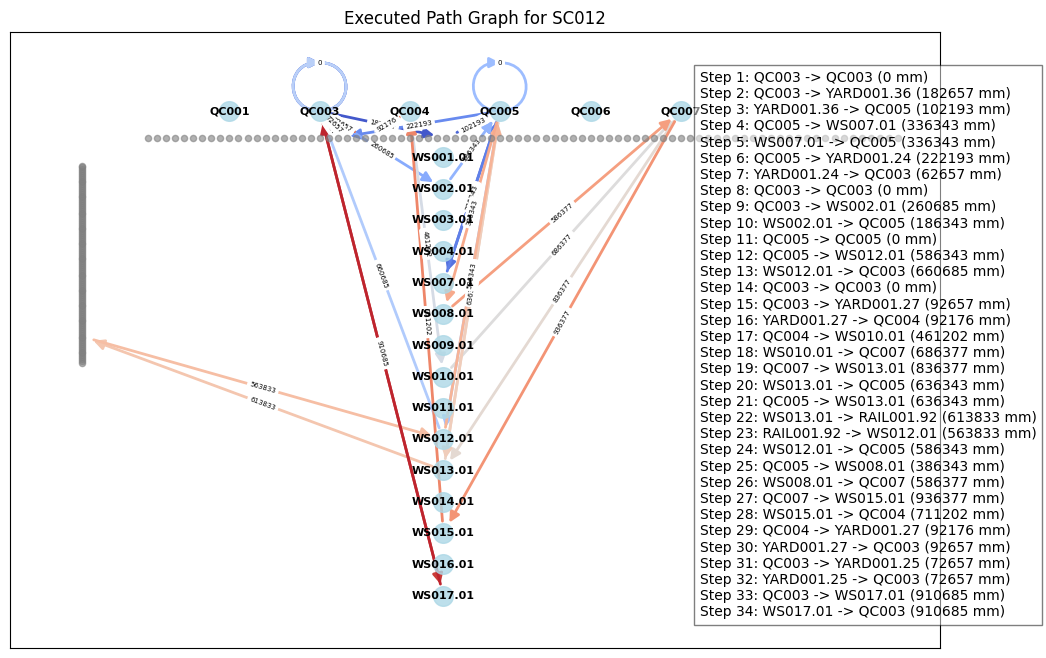

In [49]:
# ----------------------------------------------------------
# Visualize the Executed Orders of a Specific SC
# ----------------------------------------------------------
# This script reads order and location data to generate a directed graph 
# that represents the movement of a specific SC.
# ----------------------------------------------------------

SC = "SC012"  # Define the SC to analyze.

# Load Excel files containing location and order data.
df_locations = pd.read_excel("input_simu/VOSimu-InputInformation.xlsx", sheet_name="Locations")
df_orders = pd.read_excel("input_simu/VOSimu-InputInformation.xlsx", sheet_name="ContainerOrders")

# Clean data: Strip leading and trailing whitespace from all string values.
df_locations = df_locations.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df_orders = df_orders.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Rename columns for better clarity.
df_locations.rename(columns={"Location Name": "Location", "X-Coordinate [mm]": "X", "Y-Coordinate [mm]": "Y"}, inplace=True)

# Merge location coordinates with order data for both origins and destinations.
df_orders = df_orders.merge(df_locations, left_on="OriginLocation", right_on="Location", how="left")
df_orders.rename(columns={"X": "X_Origin", "Y": "Y_Origin"}, inplace=True)

df_orders = df_orders.merge(df_locations, left_on="DestinationLocation", right_on="Location", how="left")
df_orders.rename(columns={"X": "X_Dest", "Y": "Y_Dest"}, inplace=True)

# ----------------------------------------------------------
# Construct a Directed Graph of the SC's Movement
# ----------------------------------------------------------

# Create a directed graph (DiGraph) to represent the SC's movement.
G = nx.DiGraph()

# Extract location coordinates to define node positions.
pos = {row["Location"]: (row["X"], row["Y"]) for _, row in df_locations.iterrows()}
G.add_nodes_from(pos.keys())

# Retrieve the list of executed orders for the selected SC.
tractor_order_list = executed_df[f"{SC}"].dropna().tolist()

# ----------------------------------------------------------
# Generate the SC's Movement Path from Executed Orders
# ----------------------------------------------------------
ordered_locations = []
for ID in tractor_order_list:

    # Handle "waited_" orders separately (remove prefix if present).
    if ID.startswith("waited_"):
        clean_ID = ID.replace("waited_", "")
        origin = df_orders.loc[df_orders["TractorOrderId"] == clean_ID, "OriginLocation"].values[0]
        ordered_locations.append(origin)

    else:
        # Extract origin and destination for normal orders.
        origin = df_orders.loc[df_orders["TractorOrderId"] == ID, "OriginLocation"].values[0]
        destination = df_orders.loc[df_orders["TractorOrderId"] == ID, "DestinationLocation"].values[0]
        ordered_locations.append(origin)
        ordered_locations.append(destination)

# ----------------------------------------------------------
# Add Edges with Manhattan Distance Labels
# ----------------------------------------------------------
edges = []
edge_labels = {}

for i in range(len(ordered_locations) - 1):
    start, end = ordered_locations[i], ordered_locations[i + 1]
    
    # Retrieve coordinates for start and end locations.
    start_coords = df_locations.loc[df_locations["Location"] == start, ["X", "Y"]].values[0]
    end_coords = df_locations.loc[df_locations["Location"] == end, ["X", "Y"]].values[0]

    # Compute Manhattan distance (sum of absolute X and Y differences).
    manhattan_distance = abs(start_coords[0] - end_coords[0]) + abs(start_coords[1] - end_coords[1])

    # Add directed edge to the graph.
    G.add_edge(start, end)
    edges.append((start, end))
    edge_labels[(start, end)] = f"{manhattan_distance}"  # Store Manhattan distance as label.

# ----------------------------------------------------------
# Visualize the Executed Path Graph
# ----------------------------------------------------------

# Define a color gradient for edges (from blue to red).
colors = [plt.cm.coolwarm(i / len(edges)) for i in range(len(edges))]

# Separate YARD & RAIL nodes from other main nodes for different visual styling.
yard_rail_nodes = [loc for loc in pos.keys() if loc in YARD + RAIL]
main_nodes = [loc for loc in pos.keys() if loc not in YARD + RAIL]

plt.figure(figsize=(12, 8))

# Draw main locations (larger nodes with labels).
nx.draw_networkx_nodes(G, pos, nodelist=main_nodes, node_size=200, node_color="lightblue", alpha=0.8)
nx.draw_networkx_labels(G, pos, labels={loc: loc for loc in main_nodes}, font_size=8, font_weight="bold")

# Draw YARD & RAIL locations (smaller nodes, no labels).
nx.draw_networkx_nodes(G, pos, nodelist=yard_rail_nodes, node_size=20, node_color="gray", alpha=0.6)

# Draw directed edges with color gradient.
nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=colors, arrowstyle='-|>', arrowsize=15, width=2)

# Add labels for edges (Manhattan distances).
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=5, font_color="black")

# ----------------------------------------------------------
# Generate and Display the Movement Legend
# ----------------------------------------------------------

# Create a legend summarizing each movement step with its Manhattan distance.
combined_legend = []
for i in range(len(ordered_locations) - 1):
    start = ordered_locations[i]
    end = ordered_locations[i + 1]
    
    # Retrieve the Manhattan distance.
    manhattan_distance = edge_labels[(start, end)]
    
    # Format step details.
    combined_legend.append(f"Step {i+1}: {start} -> {end} ({manhattan_distance} mm)")

# Display the movement legend as text in the plot.
legend_text = "\n".join(combined_legend)
plt.gcf().text(0.7, 0.15, legend_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

# Add a title and display the plot.
plt.title(f"Executed Path Graph for {SC}")
plt.show()
